In [ ]:
import numpy as np
import pandas as pd
import pickle
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as ds
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import os
import requests
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.models as models
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/dl2')
# Run the models on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Commonly used values for CIFAR10 normalization
mean,std = [0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010]

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
transform_train = transforms.Compose([transforms.RandomRotation(20),
                                     transforms.RandomHorizontalFlip(0.1),
                                     transforms.ColorJitter(brightness = 0.1,
                                                            contrast = 0.1,
                                                            saturation = 0.1),
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std), # Normalizing with standard mean and standard deviation
                                     transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)])

# Load the data
train_dataset = ds.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testing_dataset = ds.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_dataset,testing_dataset


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
                RandomHorizontalFlip(p=0.1)
                ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=None)
                RandomAdjustSharpness(sharpness_factor=2,p=0.1)
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
                RandomErasing(p=0.75, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=1.0, inplace=False)
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
            ))

In [ ]:
# Split a validation set from test set
test_dataset, val_dataset = random_split(testing_dataset, [5000, 5000])

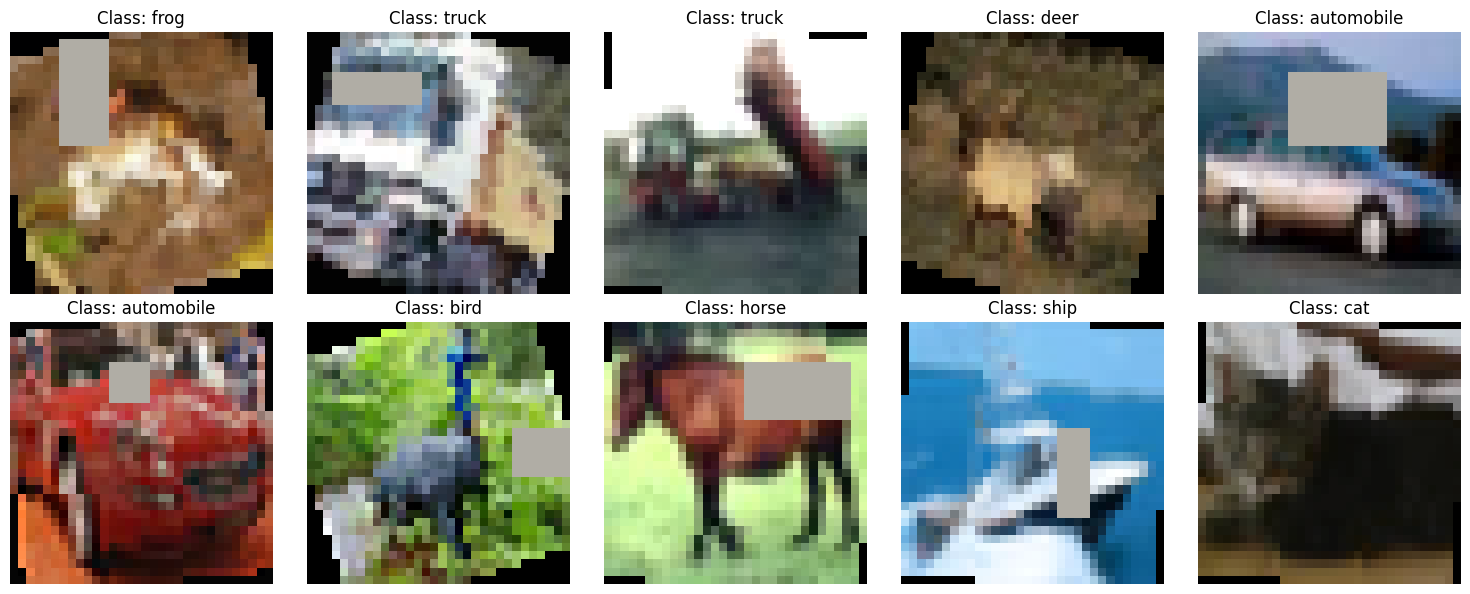

In [ ]:
# Create train, validation, and test sets for training
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# 10 classes of CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Denormalization
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Display the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    image, label = train_dataset[i]
    image = denormalize(image, mean, std)
    class_name = classes[label]
    ax = axes[i]
    ax.imshow(image.permute(1, 2, 0).clamp(0, 1))  #  ensure values are in [0, 1]
    ax.set_title(f"Class: {class_name}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5):

    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss = total_loss / len(train_loader)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                val_loss = criterion(outputs, y)
                total_val_loss += val_loss.item()

                _, predicted = torch.max(outputs, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        val_accuracy = correct / total
        val_loss = total_val_loss / len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            epochs_no_improve = 0
            best_val_loss = val_loss
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping at Epoch {epoch+1}")
                break

    # Plot training and validation loss
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.legend()
    plt.show()

    return model, train_loss_history, val_loss_history


In [ ]:
#Load a pre-trained ResNet
resnet_model4 = models.resnet34(pretrained=True)
# change the last layer to 10 classes
resnet_model4.fc = torch.nn.Linear(resnet_model4.fc.in_features,10)
torch.nn.init.xavier_uniform_(resnet_model4.fc.weight)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[-0.0696,  0.1000,  0.0428,  ..., -0.0939,  0.0007,  0.0781],
        [-0.0808, -0.1069, -0.0509,  ..., -0.0239, -0.0796,  0.0697],
        [-0.0183,  0.0750, -0.0716,  ..., -0.0242,  0.0549, -0.0222],
        ...,
        [ 0.0094, -0.0990, -0.0228,  ...,  0.0044,  0.0236,  0.0175],
        [ 0.0199,  0.0685, -0.0159,  ..., -0.0191,  0.0273,  0.0626],
        [ 0.0220, -0.0895, -0.0023,  ..., -0.0417, -0.0361, -0.0118]],
       requires_grad=True)


Training with learning rate: 0.001
Epoch 1/50, Train Loss: 1.9234, Validation Loss: 1.6613, Validation Accuracy: 0.4336
Epoch 2/50, Train Loss: 1.4560, Validation Loss: 1.3642, Validation Accuracy: 0.5172
Epoch 3/50, Train Loss: 1.3194, Validation Loss: 1.2448, Validation Accuracy: 0.5606
Epoch 4/50, Train Loss: 1.2232, Validation Loss: 1.1013, Validation Accuracy: 0.6100
Epoch 5/50, Train Loss: 1.1561, Validation Loss: 1.0700, Validation Accuracy: 0.6224
Epoch 6/50, Train Loss: 1.1054, Validation Loss: 0.9919, Validation Accuracy: 0.6430
Epoch 7/50, Train Loss: 1.0593, Validation Loss: 1.0196, Validation Accuracy: 0.6494
Epoch 8/50, Train Loss: 1.0269, Validation Loss: 0.9179, Validation Accuracy: 0.6740
Epoch 9/50, Train Loss: 0.9928, Validation Loss: 0.8893, Validation Accuracy: 0.6878
Epoch 10/50, Train Loss: 0.9662, Validation Loss: 0.8368, Validation Accuracy: 0.7098
Epoch 11/50, Train Loss: 0.9419, Validation Loss: 0.8408, Validation Accuracy: 0.7074
Epoch 12/50, Train Loss: 0.

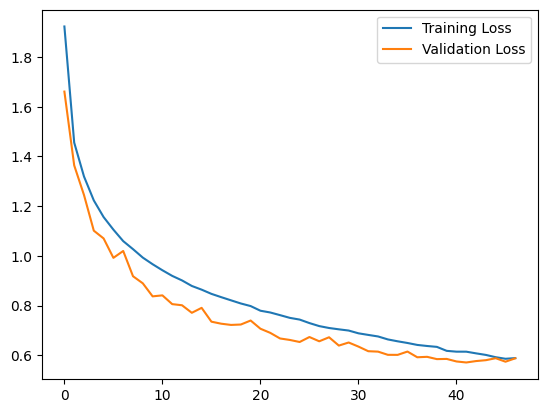

New best model saved with learning rate: 0.001 at path ResNet34+xavier.pth

Training with learning rate: 0.01
Epoch 1/50, Train Loss: 0.6678, Validation Loss: 0.6028, Validation Accuracy: 0.7920
Epoch 2/50, Train Loss: 0.6239, Validation Loss: 0.5475, Validation Accuracy: 0.8136
Epoch 3/50, Train Loss: 0.5850, Validation Loss: 0.5482, Validation Accuracy: 0.8150
Epoch 4/50, Train Loss: 0.5581, Validation Loss: 0.5419, Validation Accuracy: 0.8154
Epoch 5/50, Train Loss: 0.5345, Validation Loss: 0.5255, Validation Accuracy: 0.8196
Epoch 6/50, Train Loss: 0.5065, Validation Loss: 0.5396, Validation Accuracy: 0.8202
Epoch 7/50, Train Loss: 0.4820, Validation Loss: 0.5262, Validation Accuracy: 0.8176
Epoch 8/50, Train Loss: 0.4650, Validation Loss: 0.5283, Validation Accuracy: 0.8210
Epoch 9/50, Train Loss: 0.4443, Validation Loss: 0.5067, Validation Accuracy: 0.8330
Epoch 10/50, Train Loss: 0.4275, Validation Loss: 0.5109, Validation Accuracy: 0.8364
Epoch 11/50, Train Loss: 0.4142, Valida

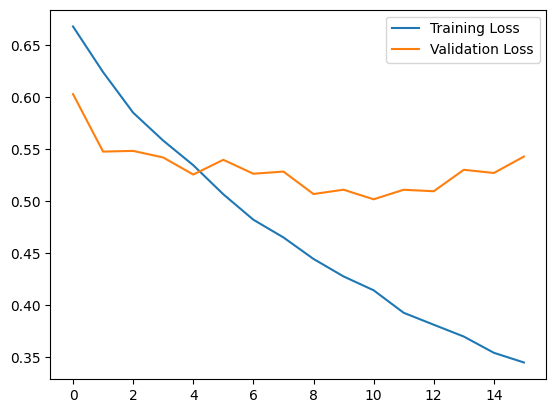

New best model saved with learning rate: 0.01 at path ResNet34+xavier.pth

Training with learning rate: 0.1
Epoch 1/50, Train Loss: 0.9228, Validation Loss: 0.7262, Validation Accuracy: 0.7566
Epoch 2/50, Train Loss: 0.6984, Validation Loss: 1.8118, Validation Accuracy: 0.7624
Epoch 3/50, Train Loss: 0.6619, Validation Loss: 0.5884, Validation Accuracy: 0.8002
Epoch 4/50, Train Loss: 0.6042, Validation Loss: 0.5731, Validation Accuracy: 0.8116
Epoch 5/50, Train Loss: 0.5197, Validation Loss: 0.5543, Validation Accuracy: 0.8194
Epoch 6/50, Train Loss: 0.4773, Validation Loss: 0.5347, Validation Accuracy: 0.8226
Epoch 7/50, Train Loss: 0.5582, Validation Loss: 0.6178, Validation Accuracy: 0.7926
Epoch 8/50, Train Loss: 0.5740, Validation Loss: 0.5397, Validation Accuracy: 0.8254
Epoch 9/50, Train Loss: 0.4317, Validation Loss: 0.5346, Validation Accuracy: 0.8284
Epoch 10/50, Train Loss: 0.4132, Validation Loss: 0.5224, Validation Accuracy: 0.8368
Epoch 11/50, Train Loss: 0.4712, Validati

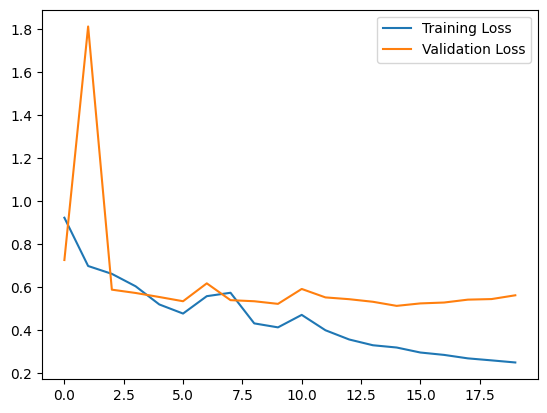

Best learning rate: 0.01


In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rates = [0.001,0.01, 0.1]
best_val_loss = float('inf')
best_model_path = 'ResNet34+xavier.pth'

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = resnet_model4.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    _, _, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer)
    if min(val_loss_history) < best_val_loss:

        best_val_loss = min(val_loss_history)

        best_lr = lr

        # Save this model

        torch.save(model.state_dict(), best_model_path)

        print(f"New best model saved with learning rate: {lr} at path {best_model_path}")


print(f"Best learning rate: {best_lr}")

In [ ]:
# Load and evaluate the best model on the test set

model = resnet_model4.to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

correct = 0
total = 0

with torch.no_grad():

    for X, y in test_loader:

        X, y = X.to(device), y.to(device)

        outputs = model(X)

        _, predicted = torch.max(outputs.data, 1)

        total += y.size(0)

        correct += (predicted == y).sum().item()


print(f"Accuracy of the best model on the test dataset: {100 * correct / total:.2f}%")

Accuracy of the best model on the test dataset: 83.46%
